In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install category-encoders

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from category_encoders import TargetEncoder, MEstimateEncoder
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
# Loading the data
train=pd.read_csv('/content/drive/My Drive/Demand Forecasting/train.csv',parse_dates=['week'])
test=pd.read_csv('/content/drive/My Drive/Demand Forecasting/test.csv',parse_dates=['week'])
sub=pd.read_csv('/content/drive/My Drive/Demand Forecasting/sub.csv')

In [5]:
# Displaying the data
print(train.shape)
display(train.head())

print(test.shape)
display(test.head())

(150150, 9)


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
0,1,2011-01-17,8091,216418,99.0375,111.8625,0,0,20
1,2,2011-01-17,8091,216419,99.0375,99.0375,0,0,28
2,3,2011-01-17,8091,216425,133.9500,133.9500,0,0,19
3,4,2011-01-17,8091,216233,133.9500,133.9500,0,0,44
4,5,2011-01-17,8091,217390,141.0750,141.0750,0,0,52


(13860, 8)


,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku
0,212645,2013-07-16,8091,216418,108.3000,108.3000,0,0
1,212646,2013-07-16,8091,216419,109.0125,109.0125,0,0
2,212647,2013-07-16,8091,216425,133.9500,133.9500,0,0
3,212648,2013-07-16,8091,216233,133.9500,133.9500,0,0
4,212649,2013-07-16,8091,217390,176.7000,176.7000,0,0


In [6]:
# Checking the datatypes
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150150 entries, 0 to 150149
Data columns (total 9 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   record_ID        150150 non-null  int64         
 1   week             150150 non-null  datetime64[ns]
 2   store_id         150150 non-null  int64         
 3   sku_id           150150 non-null  int64         
 4   total_price      150149 non-null  float64       
 5   base_price       150150 non-null  float64       
 6   is_featured_sku  150150 non-null  int64         
 7   is_display_sku   150150 non-null  int64         
 8   units_sold       150150 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6)
memory usage: 10.3 MB


In [7]:
# Checking for missing values in the train data
train.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        1
base_price         0
is_featured_sku    0
is_display_sku     0
units_sold         0
dtype: int64

In [8]:
# Checking the single missing value in the total_price column
train[train.total_price.isnull()]

,record_ID,week,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
136949,193915,2013-04-23,9436,245338,NaN,469.5375,0,0,1


In [9]:
# Checking for misssing values in the test data
test.isnull().sum()

record_ID          0
week               0
store_id           0
sku_id             0
total_price        0
base_price         0
is_featured_sku    0
is_display_sku     0
dtype: int64

In [10]:
# Summary statistics of the data
train.describe()

,record_ID,store_id,sku_id,total_price,base_price,is_featured_sku,is_display_sku,units_sold
count,150150.000000,150150.000000,150150.000000,150149.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,9199.422511,254761.132468,206.626751,219.425927,0.095611,0.133200,51.674206
std,61386.037861,615.591445,85547.306447,103.308516,110.961712,0.294058,0.339792,60.207904
min,1.000000,8023.000000,216233.000000,41.325000,61.275000,0.000000,0.000000,1.000000
25%,53111.250000,8562.000000,217217.000000,130.387500,133.237500,0.000000,0.000000,20.000000
50%,106226.500000,9371.000000,222087.000000,198.075000,205.912500,0.000000,0.000000,35.000000
75%,159452.750000,9731.000000,245338.000000,233.700000,234.412500,0.000000,0.000000,62.000000
max,212644.000000,9984.000000,679023.000000,562.162500,562.162500,1.000000,1.000000,2876.000000


In [11]:
# Summary of the data
print(f"Total number of records in the train data: {train.shape[0]}")
print(f"Total number of records in the test data: {test.shape[0]}")
print(f"Total unique Store ID: {train['store_id'].nunique()}")
print(f"Total unique SKU ID: {train['sku_id'].nunique()}")

Total number of records in the train data: 150150
Total number of records in the test data: 13860
Total unique Store ID: 76
Total unique SKU ID: 28


So, from the above exploration it is observed that:
* There is one missing value in the total_price column (which may be due to some data entry error)
* The features are of different scale
* is_featured_sku and is_display_sku are categorical type, but it is denoted as int.

In [12]:
# Changing the datatype of is_featured_sku and is_display_sku to categorical type
train['is_featured_sku'] = train['is_featured_sku'].astype('category')
train['is_display_sku'] = train['is_display_sku'].astype('category')
train['store_id'] = train['store_id'].astype('category')
train['sku_id'] = train['sku_id'].astype('category')

test['is_featured_sku'] = test['is_featured_sku'].astype('category')
test['is_display_sku'] = test['is_display_sku'].astype('category')
test['store_id'] = test['store_id'].astype('category')
test['sku_id'] = test['sku_id'].astype('category')

In [13]:
# Now we will impute the single missing value of total_price to is base_price (assuming there is no markup)
train.loc[136949, 'total_price'] = 469.5375

In [14]:
# Creating date based features
def date_features(data):
  data['year'] = data['week'].dt.year
  data['month'] = data['week'].dt.month
  data['weekofyr'] = data['week'].dt.weekofyear
  data['dayofweek'] = data['week'].dt.dayofweek
  return data

train = date_features(train)
test = date_features(test)

In [15]:
train.describe()

,record_ID,total_price,base_price,units_sold,year,month,weekofyr,dayofweek
count,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000,150150.000000
mean,106271.555504,206.628502,219.425927,51.674206,2011.830769,6.130769,24.992308,1.400000
std,61386.037861,103.310400,110.961712,60.207904,0.755887,3.438232,14.867927,1.791439
min,1.000000,41.325000,61.275000,1.000000,2011.000000,1.000000,1.000000,0.000000
25%,53111.250000,130.387500,133.237500,20.000000,2011.000000,3.000000,12.000000,0.000000
50%,106226.500000,198.075000,205.912500,35.000000,2012.000000,6.000000,23.500000,1.000000
75%,159452.750000,233.700000,234.412500,62.000000,2012.000000,9.000000,38.000000,2.000000
max,212644.000000,562.162500,562.162500,2876.000000,2013.000000,12.000000,52.000000,6.000000


In [16]:
test.describe()

,record_ID,total_price,base_price,year,month,weekofyr,dayofweek
count,13860.000000,13860.000000,13860.000000,13860.0,13860.000000,13860.000000,13860.000000
mean,222460.146392,212.188874,223.922660,2013.0,6.916667,28.750000,1.916667
std,5668.258490,93.138162,103.429522,0.0,2.465122,11.300297,1.497737
min,212645.000000,65.550000,70.537500,2013.0,1.000000,2.000000,1.000000
25%,217557.750000,132.525000,137.512500,2013.0,6.750000,27.500000,1.000000
50%,222466.500000,213.037500,218.737500,2013.0,7.500000,32.000000,1.000000
75%,227367.250000,241.537500,261.487500,2013.0,8.250000,35.750000,2.250000
max,232287.000000,562.162500,562.162500,2013.0,10.000000,41.000000,5.000000


In [17]:
train.columns

Index(['record_ID', 'week', 'store_id', 'sku_id', 'total_price', 'base_price',
       'is_featured_sku', 'is_display_sku', 'units_sold', 'year', 'month',
       'weekofyr', 'dayofweek'],
      dtype='object')

In [18]:
# Now, we will encode the store_id and sku_id using TargetEncoder
encoder = TargetEncoder()
train[['store_id', 'sku_id']] = encoder.fit_transform(train[['store_id', 'sku_id']], train['units_sold'])
test[['store_id', 'sku_id']] = encoder.transform(test[['store_id', 'sku_id']])

In [19]:
# Creating percentage discount feature from the total_price and base_price
train['Discount_Price']=train['base_price'] - train['total_price']
train['Percentage_Discount']=((train['Discount_Price'])/train['base_price'])*100

test['Discount_Price']=test['base_price'] - test['total_price']
test['Percentage_Discount']=((test['Discount_Price'])/test['base_price'])*100

In [20]:
# Checking the correlation of features with units_sold variable
train.corr()['units_sold'].sort_values()

total_price           -0.235634
base_price            -0.140032
dayofweek             -0.014479
record_ID             -0.010616
year                  -0.009180
weekofyr               0.002615
month                  0.002993
Discount_Price         0.278283
store_id               0.337334
Percentage_Discount    0.364841
sku_id                 0.376556
units_sold             1.000000
Name: units_sold, dtype: float64

In [21]:
# Feature list
features = train.drop(['units_sold', 'record_ID', 'week'], axis=1).columns
print(features)

# category features
cat_features = ['store_id', 'sku_id', 'is_featured_sku', 'is_display_sku']

Index(['store_id', 'sku_id', 'total_price', 'base_price', 'is_featured_sku',
       'is_display_sku', 'year', 'month', 'weekofyr', 'dayofweek',
       'Discount_Price', 'Percentage_Discount'],
      dtype='object')


In [22]:
# Preparing the data for modeling
X = train[features]
y = np.log(train['units_sold'])

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 0.3, random_state=123)
print(X_train.shape, y_train.shape)
print(X_valid.shape, y_valid.shape)

X_test = test[features]
print(X_test.shape)

(105105, 12) (105105,)
(45045, 12) (45045,)
(13860, 12)


In [23]:
def LGBTrain(X_train, y_train, X_valid, y_valid, cat_cols, X_test):
  # Loading the data as LGB dataset for faster operations
  train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_cols)
  valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=cat_cols)

  # Setting the parameters for the model
  params = {'objective': 'regression',
            'boosting': 'gbdt',
            'learning_rate': 0.1,
            'extra_trees': True,
            'metric':'l2',
            'min_data_in_leaf': 100,
            'verbose':1
            }
  n_estimators = 1000
  early_stopping_rounds = 5

  model = lgb.train(params=params, train_set = train_data, num_boost_round=n_estimators,
                    valid_sets = valid_data,
                    early_stopping_rounds = early_stopping_rounds,
                    )
  preds = model.predict(X_valid, num_iteration=model.best_iteration)
  error = 100*np.sqrt(mean_squared_log_error(y_valid, preds))

  # Predicting on the test set
  preds_test = model.predict(X_test, num_iteration=model.best_iteration)

  return preds, error, np.exp(preds_test), model 



In [24]:
# Running the model
pred_val, error_val, pred_test, model = LGBTrain(X_train, y_train, X_valid, y_valid, cat_features, X_test)

[1]	valid_0's l2: 0.725371
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 0.652148
[3]	valid_0's l2: 0.591288
[4]	valid_0's l2: 0.539672
[5]	valid_0's l2: 0.497747
[6]	valid_0's l2: 0.462139
[7]	valid_0's l2: 0.431186
[8]	valid_0's l2: 0.405662
[9]	valid_0's l2: 0.384184
[10]	valid_0's l2: 0.365089
[11]	valid_0's l2: 0.349909
[12]	valid_0's l2: 0.33586
[13]	valid_0's l2: 0.32396
[14]	valid_0's l2: 0.314226
[15]	valid_0's l2: 0.305513
[16]	valid_0's l2: 0.29749
[17]	valid_0's l2: 0.29123
[18]	valid_0's l2: 0.285525
[19]	valid_0's l2: 0.280069
[20]	valid_0's l2: 0.275319
[21]	valid_0's l2: 0.271197
[22]	valid_0's l2: 0.266459
[23]	valid_0's l2: 0.262758
[24]	valid_0's l2: 0.259457
[25]	valid_0's l2: 0.256786
[26]	valid_0's l2: 0.254352
[27]	valid_0's l2: 0.252032
[28]	valid_0's l2: 0.249462
[29]	valid_0's l2: 0.247193
[30]	valid_0's l2: 0.244863
[31]	valid_0's l2: 0.242868
[32]	valid_0's l2: 0.24127
[33]	valid_0's l2: 0.239424
[34]	valid_0's l2: 0.238037
[

In [25]:
print(error_val)

11.75421978046311


In [26]:
# preparing the data for checking the validation accuracy
temp = pd.DataFrame(y_valid)
temp['preds'] = pred_val
temp['month'] = X_valid['month']
temp.head()

,units_sold,preds,month
137018,3.044522,3.448989,4
27000,3.332205,3.651202,6
79642,3.178054,3.146107,8
126501,3.218876,2.884870,2
111156,2.079442,3.261096,11


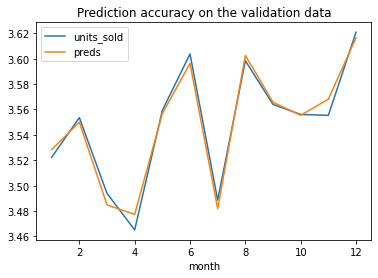

In [27]:
temp_grp = temp.groupby('month').mean()

# Plotting the Validation data
temp_grp.plot(kind='line')
plt.title("Prediction accuracy on the validation data")
plt.show()

In [28]:
# Creating the submission file
sub['units_sold'] = pred_test
sub.head()

,record_ID,units_sold
0,212645,20.698637
1,212646,20.826133
2,212647,16.968475
3,212648,26.209534
4,212649,20.700304


In [29]:
# sub.to_csv("LGBM_4.csv", index=False)